In [10]:
# 开启多行显示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

# 显示图片
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 数据探索

In [2]:
import pandas as pd
import numpy as np
import nltk
import pickle
import os

In [4]:
train = pd.read_csv("../data/crowdflower-search-relevance/train.csv")
test = pd.read_csv("../data/crowdflower-search-relevance/test.csv")

In [5]:
train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [6]:
test.head()

,id,query,product_title,product_description
0,3,electric griddle,Star-Max 48 in Electric Griddle,NaN
1,6,phillips coffee maker,Philips SENSEO HD7810 WHITE Single Serve Pod C...,NaN
2,9,san francisco 49ers,2013 San Francisco 49ers Clock,A 2013 San Francisco 49ers clock is the ultima...
3,11,aveeno shampoo,AVEENO 10.5FLOZ NRSH SHINE SH,"Water, Ammonium Lauryl Sulfate, Dimethicone, S..."
4,12,flea and tick control for dogs,Merial Frontline Plus Flea and Tick Control fo...,NaN


此处 train.csv 中的每列含义：

id: 产品id

query: 搜索词语

product_title：产品标题

product_description: 产品描述的完整文本（部分带有HTML标签）

median_relevance: 三位评分员的相关性评分中位数. 值为1到4的整数.

relevance_variance: 评分员的相关性评分的方差.

其中我们的目标值是 median_relevance ， relevance_variance 则可以作为一个数据可靠性的参考，观察数据我们能从中提取的特征主要就是文本特征。

In [7]:
print(len(train),len(test))

10158 22513


我们有1w条训练数据，2w条测试数据

In [11]:
train['query'].unique()[0:10]
len(train['query'].unique())
len(test['query'].unique())

array(['bridal shower decorations', 'led christmas lights', 'projector',
       'wine rack', 'light bulb', 'oakley polarized radar',
       'boyfriend jeans', 'screen protector samsung', 'pots and pans set',
       'waffle maker'], dtype=object)

261

261

In [12]:
train['product_title'].unique()[0:10]

len(train['product_title'].unique())

len(test['product_title'].unique())

array(['Accent Pillow with Heart Design - Red/Black',
       'Set of 10 Battery Operated Multi LED Train Christmas Lights - Clear Wire',
       'ViewSonic Pro8200 DLP Multimedia Projector',
       'Concept Housewares WR-44526 Solid-Wood Ceiling/Wall-Mount Wine Rack, Charcoal Grey, 6 Bottle',
       'Wintergreen Lighting Christmas LED Light Bulb (Pack of 25)',
       'Oakley Sunglasses - Radar Path Polished Black/Gray Sunglasses',
       'How To Make An American Quilt (DVD)',
       'ZAGG InvisibleShield Cell Phone Screen Protector for Samsung Galaxy S4 Mini',
       'Cook N Home Stainless Steel 4-Piece Pasta Cooker/ Steamer Multi-pots with Encapsulated Bottom, 8-Quart',
       'Presto FlipSide Electric Waffle Maker- 03510'], dtype=object)

9708

21110

同一个 query 会和不同的文档组成集合对，大多数文档会有多个query

In [13]:
# unique values in `test` that are not in `train`.
len(np.setdiff1d(test['product_title'].unique(),train['product_title'].unique()))
# 并集
len(np.intersect1d(test['product_title'].unique(),train['product_title'].unique()))

20082

1028

测试集合和训练集合标题重叠的不多

In [14]:
query = train['query'].map(nltk.tokenize.word_tokenize)

from nltk.corpus import stopwords
stopset = set(stopwords.words('english'))

In [15]:
def key_plot(data,col,top_num=10):  
    s= data[col].map(nltk.tokenize.word_tokenize)
    fdist=nltk.FreqDist( words.lower()  for x in s
                    for words in x if words.lower() not in stopset )
    top=pd.DataFrame(fdist.most_common(top_num),columns=['query','times'])
    top=top.set_index('query')
    top.plot(kind='bar')

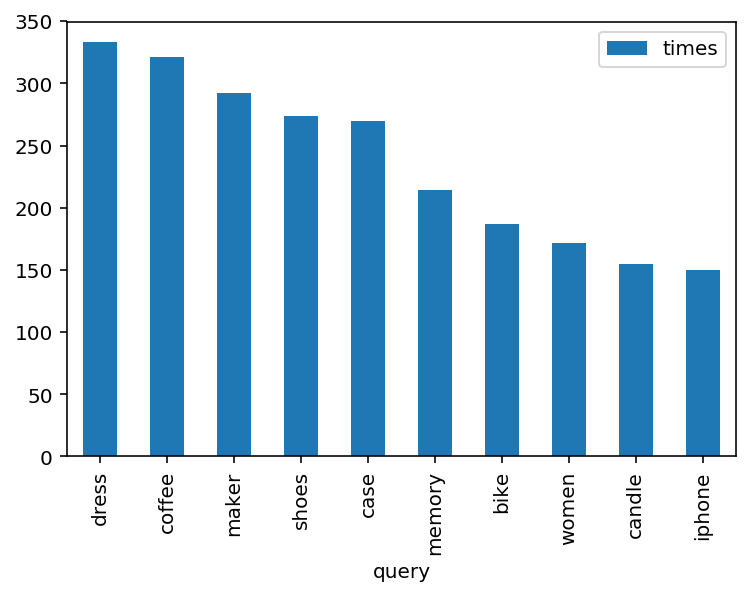

In [16]:
key_plot(train,'query')

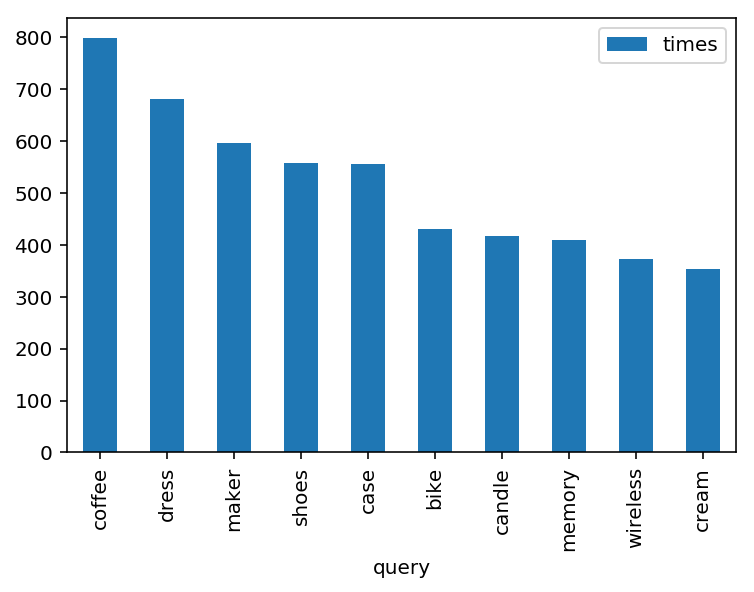

In [17]:
key_plot(test,'query')

## 数据预处理

In [18]:
dfTrain = pd.read_csv("../data/crowdflower-search-relevance/train.csv").fillna("")
dfTest = pd.read_csv("../data/crowdflower-search-relevance/test.csv").fillna("")

In [19]:
# number of train/test samples
num_train, num_test = dfTrain.shape[0], dfTest.shape[0]

In [20]:
dfTest["median_relevance"] = np.ones((num_test))
dfTest["relevance_variance"] = np.zeros((num_test))

In [21]:
## insert sample index
dfTrain["index"] = np.arange(num_train)
dfTest["index"] = np.arange(num_test)

In [22]:
## one-hot encode the median_relevance
for i in range(4):
    dfTrain["median_relevance_%d" % (i+1)] = 0
    # 先选行，再选列
    dfTrain.loc[dfTrain["median_relevance"]==(i+1), "median_relevance_%d" % (i+1)] = 1

In [23]:
# pd.get_dummies(dfTrain['median_relevance'],prefix='median_relevance')

In [24]:
## query ids
qid_dict = dict()
for i,q in enumerate(np.unique(dfTrain["query"]), start=1):
    qid_dict[q] = i

In [25]:
len(np.setdiff1d(test['query'].unique(),train['query'].unique()))

0

In [37]:
## insert query id
dfTrain["qid"] = dfTrain["query"].apply(lambda q: qid_dict[q])
dfTest["qid"] = dfTest["query"].apply(lambda q: qid_dict[q])

In [55]:
# 定义在最后
clean = lambda line: clean_text(line, drop_html_flag=True)
dfTrain = dfTrain.apply(clean, axis=1)
dfTest = dfTest.apply(clean, axis=1)

/root/anaconda3/envs/wc/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /root/anaconda3/envs/wc/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))
/root/anaconda3/envs/wc/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65497012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to 

In [56]:
dfTrain.head()

,id,query,product_title,product_description,median_relevance,relevance_variance,index,median_relevance_1,median_relevance_2,median_relevance_3,median_relevance_4,qid
0,1,bridal shower decorations,accent pillow with heart design - red/black,red satin accent pillow embroidered with a hea...,1,0.000,0,1,0,0,0,31
1,2,led christmas lights,set of 10 battery operated multi led train chr...,set of 10 battery operated train christmas lig...,4,0.000,1,0,0,0,1,122
2,4,projector,viewsonic pro8200 dlp multimedia projector,,4,0.471,2,0,0,0,1,171
3,5,wine rack,concept housewares wr-44526 solid-wood ceiling...,"like a silent and sturdy tree, the southern en...",4,0.000,3,0,0,0,1,250
4,7,light bulb,wintergreen lighting christmas led light bulb ...,"wtgr1011\nfeatures\nnickel base, 60,000 averag...",2,0.471,4,0,1,0,0,128


In [60]:
if not os.path.exists("../data/crowdflower-search-relevance/Feat/solution/"):
    os.mkdirs("../data/crowdflower-search-relevance/Feat/solution/")
# 存储数据
import pickle
with open("../data/crowdflower-search-relevance/Feat/solution/train.processed.csv.pkl", "wb") as f:
    pickle.dump(dfTrain,f)
with open("../data/crowdflower-search-relevance/Feat/solution/test.processed.csv.pkl", "wb") as f:
    pickle.dump(dfTest, f)

## 交叉验证

In [61]:
from sklearn.cross_validation import StratifiedKFold

skf = [0]*3
for stratified_label,key in zip(["relevance", "query"], ["median_relevance", "qid"]):
    print(stratified_label, key)
    for run in range(3):
        random_seed = 2017 + 1000 * (run+1)
        skf[run] = StratifiedKFold(dfTrain[key], n_folds=3,
                                        shuffle=True, random_state=random_seed)
        for fold, (validInd, trainInd) in enumerate(skf[run]):
                print("================================")
                print("Index for run: %s, fold: %s" % (run+1, fold+1))
                print("Train (num = %s)" % len(trainInd))
                print(trainInd[:10])
                print("Valid (num = %s)" % len(validInd))
                print(validInd[:10])
    with open("%s/stratifiedKFold.%s.pkl" % ("../data/crowdflower-search-relevance", stratified_label), "wb") as f:
        pickle.dump(skf, f)     

/root/anaconda3/envs/wc/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


relevance median_relevance
Index for run: 1, fold: 1
Train (num = 3386)
[ 5  7  8 10 17 19 20 22 25 27]
Valid (num = 6772)
[ 0  1  2  3  4  6  9 11 12 13]
Index for run: 1, fold: 2
Train (num = 3386)
[ 0  1  2  4  9 11 14 15 16 23]
Valid (num = 6772)
[ 3  5  6  7  8 10 12 13 17 18]
Index for run: 1, fold: 3
Train (num = 3386)
[ 3  6 12 13 18 21 31 32 33 34]
Valid (num = 6772)
[ 0  1  2  4  5  7  8  9 10 11]
Index for run: 2, fold: 1
Train (num = 3386)
[ 1  2  3  5  7 14 16 20 22 24]
Valid (num = 6772)
[ 0  4  6  8  9 10 11 12 13 15]
Index for run: 2, fold: 2
Train (num = 3386)
[ 0  4  6  8 10 12 15 17 18 19]
Valid (num = 6772)
[ 1  2  3  5  7  9 11 13 14 16]
Index for run: 2, fold: 3
Train (num = 3386)
[ 9 11 13 21 23 32 36 38 39 41]
Valid (num = 6772)
[ 0  1  2  3  4  5  6  7  8 10]
Index for run: 3, fold: 1
Train (num = 3386)
[ 0  1  4  7  8 17 18 19 20 23]
Valid (num = 6772)
[ 2  3  5  6  9 10 11 12 13 14]
Index for run: 3, fold: 2
Train (num = 3386)
[ 2  3  5 10 11 13 16 21 22 24]


## 特征提取
### id 特征提取

In [62]:
feat_folder = "../data/crowdflower-search-relevance/Feat/solution"
n_runs=3

In [63]:
## load pre-defined stratified k-fold index
with open("%s/stratifiedKFold.%s.pkl" % ("../data/crowdflower-search-relevance", "query"), "rb") as f:
    skf = pickle.load(f)

In [64]:
from sklearn.preprocessing import LabelBinarizer
## 下面开始产生id特征，思路就是进行one-hot-encoding，此处能这么做的原因主要还是因为此处 query_id 还是比较少
id_names = ["qid"]
for run in range(3):
    # 其中 33% 用于训练，67% 用于验证
    for fold, (validInd, trainInd) in enumerate(skf[run]):
        print("Run: %d, Fold: %d" % (run+1, fold+1))
        path = "%s/Run%d/Fold%d" % (feat_folder, run+1, fold+1)
        if (not os.path.exists(path)):
            os.makedirs(path)
        
        for id_name in id_names:
            lb = LabelBinarizer(sparse_output=True)
            X_train = lb.fit_transform(dfTrain.iloc[trainInd][id_name])
            X_valid = lb.transform(dfTrain.iloc[validInd][id_name])
            with open("%s/train.%s.feat.pkl" % (path, id_name), "wb") as f:
                pickle.dump(X_train, f)
            with open("%s/valid.%s.feat.pkl" % (path, id_name), "wb") as f:
                pickle.dump(X_valid, f)
# 对所有数据产生 feature 
print("For training and testing...")
path = "%s/All" % feat_folder
if (not os.path.exists(path)):
    os.makedirs(path)
## use full version for X_train                
for id_name in id_names:
    X_train = lb.fit_transform(dfTrain[id_name])
    X_test = lb.transform(dfTest[id_name])
    with open("%s/train.%s.feat.pkl" % (path, id_name), "wb") as f:
        pickle.dump(X_train, f, -1)
    with open("%s/test.%s.feat.pkl" % (path, id_name), "wb") as f:
        pickle.dump(X_test, f, -1)
print("Done.")

Run: 1, Fold: 1
Run: 1, Fold: 2
Run: 1, Fold: 3
Run: 2, Fold: 1
Run: 2, Fold: 2
Run: 2, Fold: 3
Run: 3, Fold: 1
Run: 3, Fold: 2
Run: 3, Fold: 3
For training and testing...
Done.


### 连续型特征提取 
1. 基本类型
    1.1 提取 query/title/description 中的 n-gram 特征

先定义预处理函数，我们要对文本进行分词，然后进行归一化操作

In [65]:
english_stemmer = nltk.stem.PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed

In [66]:
token_pattern = r"(?u)\b\w\w+\b"
#token_pattern = r'\w{1,}'
#token_pattern = r"\w+"
#token_pattern = r"[\w']+"
def preprocess_data(line,
                    token_pattern=token_pattern,
                    exclude_stopword=False,
                    encode_digit=False):
    token_pattern = re.compile(token_pattern, flags = re.UNICODE)
    ## tokenize
    tokens = [x.lower() for x in token_pattern.findall(line)]
    ## stem
    tokens_stemmed = stem_tokens(tokens, english_stemmer)
    if exclude_stopword:
        tokens_stemmed = [x for x in tokens_stemmed if x not in stopwords]
    return tokens_stemmed

from nltk.util import ngrams
def getBigram(words, join_string, skip=0):
    lst = []
    if len(words) > 1 :
        for gram in ngrams(words, 2):
            lst.append(join_string.join(gram))
    else:
        lst = words
    return lst
def getTrigram(words, join_string, skip=0):
    lst = []
    if len(words) > 2 :
        for gram in ngrams(words, 3):
            lst.append(join_string.join(gram))
    else:
        lst = getBigram(words, join_string, skip)
    return lst

def try_divide(x, y, val=0.0):
    """ 
        Try to divide two numbers
    """
    if y != 0.0:
        val = float(x) / y
    return val

def get_position_list(target, obs):
    """
        Get the list of positions of obs in target
    """
    pos_of_obs_in_target = [0]
    if len(obs) != 0:
        pos_of_obs_in_target = [j for j,w in enumerate(obs, start=1) if w in target]
        if len(pos_of_obs_in_target) == 0:
            pos_of_obs_in_target = [0]
    return pos_of_obs_in_target

In [67]:
def extract_feat(df):
    # 先产生 unigram 特征
    df["query_unigram"] = df.apply(lambda x: preprocess_data(x["query"]), axis=1)
    df["title_unigram"] = df.apply(lambda x: preprocess_data(x["product_title"]), axis=1)
    df["description_unigram"] = df.apply(lambda x: preprocess_data(x["product_description"]), axis=1)
    
    
    # 二元gram
    join_str = "_"
    df["query_bigram"] = list(df.apply(lambda x: getBigram(x["query_unigram"], join_str), axis=1))
    df["title_bigram"] = list(df.apply(lambda x: getBigram(x["title_unigram"], join_str), axis=1))
    df["description_bigram"] = list(df.apply(lambda x: getBigram(x["description_unigram"], join_str), axis=1))

    join_str = "_"
    df["query_trigram"] = list(df.apply(lambda x: getTrigram(x["query_unigram"], join_str), axis=1))
    df["title_trigram"] = list(df.apply(lambda x: getTrigram(x["title_unigram"], join_str), axis=1))
    df["description_trigram"] = list(df.apply(lambda x: getTrigram(x["description_unigram"], join_str), axis=1))

#     统计单词和数字出现的个数以及比例

#     count_of_query_unigram query 的 unigram 个数
#     count_of_unique_query_unigram query 的 unigram 去重后的个数
#     ratio_of_unique_query_unigram  count_of_unique_query_unigram / count_of_query_unigram

#     count_of_digit_in_query query 中 数字的个数
#     ratio_of_digit_in_query count_of_digit_in_query / count_of_query_unigram
    feat_names = ["query", "title", "description"]
    grams = ["unigram", "bigram", "trigram"]
    count_digit = lambda x: sum([1. for w in x if w.isdigit()])
    for feat_name in feat_names:
        for gram in grams:
            ## word count
            df["count_of_%s_%s"%(feat_name,gram)] = list(df.apply(lambda x: len(x[feat_name+"_"+gram]), axis=1))
            df["count_of_unique_%s_%s"%(feat_name,gram)] = list(df.apply(lambda x: len(set(x[feat_name+"_"+gram])), axis=1))
            df["ratio_of_unique_%s_%s"%(feat_name,gram)] = list(map(try_divide, df["count_of_unique_%s_%s"%(feat_name,gram)], df["count_of_%s_%s"%(feat_name,gram)]))

        ## digit count
        df["count_of_digit_in_%s"%feat_name] = list(df.apply(lambda x: count_digit(x[feat_name+"_unigram"]), axis=1))
        df["ratio_of_digit_in_%s"%feat_name] = list(map(try_divide, df["count_of_digit_in_%s"%feat_name], df["count_of_%s_unigram"%(feat_name)]))

    ## description missing indicator
    df["description_missing"] = list(df.apply(lambda x: int(x["description_unigram"] == ""), axis=1))

    #### unigram
#     下面是统计联合关系

#     count_of_query_unigram_in_title 在 query_unigram 中同时也在 title_unigram 的单词的个数
#     ratio_of_query_unigram_in_title count_of_query_unigram_in_title / count_of_query_unigram

#     同时在title和query中的单词个数 / query的个数
#     title_unigram_in_query_div_query_unigram = count_of_title_unigram_in_query /count_of_query_unigram
#     title_unigram_in_query_div_query_unigram_in_title = count_of_title_unigram_in_query / count_of_query_unigram_in_title

#     注意：此处 count_of_title_unigram_in_query 和 count_of_query_unigram_in_title 的区别
#     由于两个不是集合，所以会出现单词集合都是一样，但是个数会不同的情况
    for gram in grams:
        for obs_name in feat_names:
            for target_name in feat_names:
                if target_name != obs_name:
                    ## query
                    df["count_of_%s_%s_in_%s"%(obs_name,gram,target_name)] = list(df.apply(lambda x: sum([1. for w in x[obs_name+"_"+gram] if w in set(x[target_name+"_"+gram])]), axis=1))
                    df["ratio_of_%s_%s_in_%s"%(obs_name,gram,target_name)] = list(map(try_divide, df["count_of_%s_%s_in_%s"%(obs_name,gram,target_name)], df["count_of_%s_%s"%(obs_name,gram)]))

        ## some other feat
        df["title_%s_in_query_div_query_%s"%(gram,gram)] = list(map(try_divide, df["count_of_title_%s_in_query"%gram], df["count_of_query_%s"%gram]))
        df["title_%s_in_query_div_query_%s_in_title"%(gram,gram)] = list(map(try_divide, df["count_of_title_%s_in_query"%gram], df["count_of_query_%s_in_title"%gram]))
        df["description_%s_in_query_div_query_%s"%(gram,gram)] = list(map(try_divide, df["count_of_description_%s_in_query"%gram], df["count_of_query_%s"%gram]))
        df["description_%s_in_query_div_query_%s_in_description"%(gram,gram)] = list(map(try_divide, df["count_of_description_%s_in_query"%gram], df["count_of_query_%s_in_description"%gram]))

        
    for gram in grams:
        for target_name in feat_names:
            for obs_name in feat_names:
                if target_name != obs_name:
                    # obs中出现在target中词的位置
                    pos = list(df.apply(lambda x: get_position_list(x[target_name+"_"+gram], obs=x[obs_name+"_"+gram]), axis=1))
                    ## stats feat on pos
                    df["pos_of_%s_%s_in_%s_min" % (obs_name, gram, target_name)] = list(map(np.min, pos))
                    df["pos_of_%s_%s_in_%s_mean" % (obs_name, gram, target_name)] = list(map(np.mean, pos))
                    df["pos_of_%s_%s_in_%s_median" % (obs_name, gram, target_name)] = list(map(np.median, pos))
                    df["pos_of_%s_%s_in_%s_max" % (obs_name, gram, target_name)] = list(map(np.max, pos))
                    df["pos_of_%s_%s_in_%s_std" % (obs_name, gram, target_name)] = list(map(np.std, pos))
                    ## stats feat on normalized_pos
#                     pos_of_query_unigram_in_title ： query 中出现在 title 中的词 pos_of_query_unigram_in_title_min normalized_pos_of_query_unigram_in_title_min ： 用长度进行标准化
                    df["normalized_pos_of_%s_%s_in_%s_min" % (obs_name, gram, target_name)] = list(map(try_divide, df["pos_of_%s_%s_in_%s_min" % (obs_name, gram, target_name)], df["count_of_%s_%s" % (obs_name, gram)]))
                    df["normalized_pos_of_%s_%s_in_%s_mean" % (obs_name, gram, target_name)] = list(map(try_divide, df["pos_of_%s_%s_in_%s_mean" % (obs_name, gram, target_name)], df["count_of_%s_%s" % (obs_name, gram)]))
                    df["normalized_pos_of_%s_%s_in_%s_median" % (obs_name, gram, target_name)] = list(map(try_divide, df["pos_of_%s_%s_in_%s_median" % (obs_name, gram, target_name)], df["count_of_%s_%s" % (obs_name, gram)]))
                    df["normalized_pos_of_%s_%s_in_%s_max" % (obs_name, gram, target_name)] = list(map(try_divide, df["pos_of_%s_%s_in_%s_max" % (obs_name, gram, target_name)], df["count_of_%s_%s" % (obs_name, gram)]))
                    df["normalized_pos_of_%s_%s_in_%s_std" % (obs_name, gram, target_name)] = list(map(try_divide, df["pos_of_%s_%s_in_%s_std" % (obs_name, gram, target_name)] , df["count_of_%s_%s" % (obs_name, gram)]))


In [68]:
extract_feat(dfTrain)

In [69]:
feat_names = [
    name for name in dfTrain.columns \
        if "count" in name \
        or "ratio" in name \
        or "div" in name \
        or "pos_of" in name
]
feat_names.append("description_missing")
len(feat_names)

262

对于 cv 分别产生特征保存

In [70]:
for run in range(n_runs):
    ## use 33% for training and 67 % for validation
    ## so we switch trainInd and validInd
    for fold, (validInd, trainInd) in enumerate(skf[run]):
        print("Run: %d, Fold: %d" % (run+1, fold+1))
        path = "%s/Run%d/Fold%d" % (feat_folder, run+1, fold+1)

        #########################
        ## get word count feat ##
        #########################
        for feat_name in feat_names:
            X_train = dfTrain[feat_name].values[trainInd]
            X_valid = dfTrain[feat_name].values[validInd]
            with open("%s/train.%s.feat.pkl" % (path, feat_name), "wb") as f:
                pickle.dump(X_train, f, -1)
            with open("%s/valid.%s.feat.pkl" % (path, feat_name), "wb") as f:
                pickle.dump(X_valid, f, -1)

Run: 1, Fold: 1
Run: 1, Fold: 2
Run: 1, Fold: 3
Run: 2, Fold: 1
Run: 2, Fold: 2
Run: 2, Fold: 3
Run: 3, Fold: 1
Run: 3, Fold: 2
Run: 3, Fold: 3


In [71]:
print("For training and testing...")
path = "%s/All" % feat_folder
## use full version for X_train
extract_feat(dfTest)
for feat_name in feat_names:
    X_train = dfTrain[feat_name].values
    X_test = dfTest[feat_name].values
    with open("%s/train.%s.feat.pkl" % (path, feat_name), "wb") as f:
        pickle.dump(X_train, f, -1)
    with open("%s/test.%s.feat.pkl" % (path, feat_name), "wb") as f:
        pickle.dump(X_test, f, -1)

For training and testing...


In [72]:
feat_name_file = "%s/counting.feat_name" % feat_folder
def dump_feat_name(feat_names, feat_name_file):
    """
        save feat_names to feat_name_file
    """
    with open(feat_name_file, "w") as f:
        for i,feat_name in enumerate(feat_names):
            if feat_name.startswith("count") or feat_name.startswith("pos_of"):
                f.write("('%s', SimpleTransform(count_feat_transform)),\n" % feat_name)
            else:
                f.write("('%s', SimpleTransform()),\n" % feat_name)

In [73]:
# 保存数据
dump_feat_name(feat_names, feat_name_file)

### 距离 特征
Dice 系数 ，是一种集合相似度度量函数，通常用于计算两个样本的相似度
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/21c4fb2e351a947237508fd0e775bfa01e85ff49)

Jaccard similarity 相似性系数
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)

In [74]:
def JaccardCoef(A, B):
    A, B = set(A), set(B)
    intersect = len(A.intersection(B))
    union = len(A.union(B))
    coef = try_divide(intersect, union)
    return coef

def DiceDist(A, B):
    A, B = set(A), set(B)
    intersect = len(A.intersection(B))
    union = len(A) + len(B)
    d = try_divide(2*intersect, union)
    return d

def compute_dist(A, B, dist="jaccard_coef"):
    if dist == "jaccard_coef":
        d = JaccardCoef(A, B)
    elif dist == "dice_dist":
        d = DiceDist(A, B)
    return d

In [75]:
## file to save feat names
feat_name_file = "%s/distance.feat_name" % feat_folder

In [76]:
def extract_basic_distance_feat(df):
    dists = ["jaccard_coef", "dice_dist"]
    grams = ["unigram", "bigram", "trigram"]
    feat_names = ["query", "title", "description"]
    for dist in dists:
        for gram in grams:
            for i in range(len(feat_names)-1):
                for j in range(i+1,len(feat_names)):
                    target_name = feat_names[i]
                    obs_name = feat_names[j]
                    df["%s_of_%s_between_%s_%s"%(dist,gram,target_name,obs_name)] = \
                            list(df.apply(lambda x: compute_dist(x[target_name+"_"+gram], x[obs_name+"_"+gram], dist), axis=1))

In [77]:
# 产生基本的距离特征
extract_basic_distance_feat(dfTrain)
feat_names = [name for name in dfTrain.columns if "jaccard_coef" in name or "dice_dist" in name]

In [78]:
print("For cross-validation...")
for run in range(n_runs):
    ## use 33% for training and 67 % for validation
    ## so we switch trainInd and validInd
    for fold, (validInd, trainInd) in enumerate(skf[run]):
        print("Run: %d, Fold: %d" % (run+1, fold+1))
        path = "%s/Run%d/Fold%d" % (feat_folder, run+1, fold+1)

        for feat_name in feat_names:
            X_train = dfTrain[feat_name].values[trainInd]
            X_valid = dfTrain[feat_name].values[validInd]
            with open("%s/train.%s.feat.pkl" % (path, feat_name), "wb") as f:
                pickle.dump(X_train, f, -1)
            with open("%s/valid.%s.feat.pkl" % (path, feat_name), "wb") as f:
                pickle.dump(X_valid, f, -1)
print("Done.")

For cross-validation...
Run: 1, Fold: 1
Run: 1, Fold: 2
Run: 1, Fold: 3
Run: 2, Fold: 1
Run: 2, Fold: 2
Run: 2, Fold: 3
Run: 3, Fold: 1
Run: 3, Fold: 2
Run: 3, Fold: 3
Done.


In [79]:
print("For training and testing...")
path = "%s/All" % feat_folder
## use full version for X_train
extract_basic_distance_feat(dfTest)
for feat_name in feat_names:
    X_train = dfTrain[feat_name].values
    X_test = dfTest[feat_name].values
    with open("%s/train.%s.feat.pkl" % (path, feat_name), "wb") as f:
        pickle.dump(X_train, f, -1)
    with open("%s/test.%s.feat.pkl" % (path, feat_name), "wb") as f:
        pickle.dump(X_test, f, -1)

For training and testing...


In [80]:
 ## save feat names
print("Feature names are stored in %s" % feat_name_file)
## dump feat name
dump_feat_name(feat_names, feat_name_file)

Feature names are stored in ../data/crowdflower-search-relevance/Feat/solution/distance.feat_name


### 产生基本的 tf-idf 特征

In [81]:
from copy import copy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import vstack

In [82]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

In [83]:
token_pattern = r"(?u)\b\w\w+\b"
#token_pattern = r'\w{1,}'
#token_pattern = r"\w+"
#token_pattern = r"[\w']+"
tfidf__norm = "l2"
tfidf__max_df = 0.75 # 出现不超过 75%
tfidf__min_df = 3 # 最少出现3次
def getTFV(token_pattern = token_pattern,
           norm = tfidf__norm,
           max_df = tfidf__max_df,
           min_df = tfidf__min_df,
           ngram_range = (1, 1),
           vocabulary = None,
           stop_words = 'english'):
    tfv = StemmedTfidfVectorizer(min_df=min_df, max_df=max_df, max_features=None, 
                                 strip_accents='unicode', analyzer='word', token_pattern=token_pattern,
                                 ngram_range=ngram_range, use_idf=1, smooth_idf=1, sublinear_tf=1,
                                 stop_words = stop_words, norm=norm, vocabulary=vocabulary)
    return tfv

In [84]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

token_pattern = r"(?u)\b\w\w+\b"
#token_pattern = r'\w{1,}'
#token_pattern = r"\w+"
#token_pattern = r"[\w']+"
bow__max_df = 0.75
bow__min_df = 3
def getBOW(token_pattern = token_pattern,
           max_df = bow__max_df,
           min_df = bow__min_df,
           ngram_range = (1, 1),
           vocabulary = None,
           stop_words = 'english'):
    bow = StemmedCountVectorizer(min_df=min_df, max_df=max_df, max_features=None, 
                                 strip_accents='unicode', analyzer='word', token_pattern=token_pattern,
                                 ngram_range=ngram_range,
                                 stop_words = stop_words, vocabulary=vocabulary)
    return bow

In [85]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_sim(x, y):
    try:
        d = cosine_similarity(x, y)
        d = d[0][0]
    except:
#         print(x,y)
        d = 0.
    return d

In [86]:
## extract all features
ngram_range = (1,3)
svd_n_components = [100, 150]
tsne_n_components = [2]
def extract_tfidf_feat(path, dfTrain, dfTest, mode, feat_names, column_names):
    new_feat_names = copy(feat_names)
    if vocabulary_type == "common":
        if vec_type == "tfidf":
            vec = getTFV(ngram_range=ngram_range)
        elif vec_type == "bow":
            vec = getBOW(ngram_range=ngram_range)
        vec.fit(dfTrain["all_text"])
        vocabulary = vec.vocabulary_
    elif vocabulary_type == "individual":
        vocabulary = None
    for feat_name,column_name in zip(feat_names, column_names):
        print("generate %s feat for %s" % (vec_type, column_name))
        if vec_type == "tfidf":
            vec = getTFV(ngram_range=ngram_range, vocabulary=vocabulary)
        elif vec_type == "bow":
            vec = getBOW(ngram_range=ngram_range, vocabulary=vocabulary)    
        X_train = vec.fit_transform(dfTrain[column_name])
        X_test = vec.transform(dfTest[column_name])
        with open("%s/train.%s.feat.pkl" % (path, feat_name), "wb") as f:
            pickle.dump(X_train, f, -1)
        with open("%s/%s.%s.feat.pkl" % (path, mode, feat_name), "wb") as f:
            pickle.dump(X_test, f, -1)
    #####################
    ## cosine sim feat ##
    #####################
    for i in range(len(feat_names)-1):
        for j in range(i+1,len(feat_names)):
            print("generate common %s cosine sim feat for %s and %s" % (vec_type, feat_names[i], feat_names[j]))
            for mod in ["train", mode]:
                with open("%s/%s.%s.feat.pkl" % (path, mod, feat_names[i]), "rb") as f:
                    target_vec = pickle.load(f)
                with open("%s/%s.%s.feat.pkl" % (path, mod, feat_names[j]), "rb") as f:
                    obs_vec = pickle.load(f)
                sim = np.asarray(list(map(cosine_sim, target_vec, obs_vec)))[:,np.newaxis]
                ## dump feat
                with open("%s/%s.%s_%s_%s_cosine_sim.feat.pkl" % (path, mod, feat_names[i], feat_names[j], vec_type), "wb") as f:
                    pickle.dump(sim, f, -1)
            ## update feat names
            new_feat_names.append( "%s_%s_%s_cosine_sim" % (feat_names[i], feat_names[j], vec_type))
    ##################
    ## SVD features ##
    ##################
    ## we fit svd use stacked query/title/description bow/tfidf for further cosine simalirity computation
    for i,feat_name in enumerate(feat_names):
        with open("%s/train.%s.feat.pkl" % (path, feat_name), "rb") as f:
            X_vec_train = pickle.load(f)
        if i == 0:
            X_vec_all_train = X_vec_train
        else:
            X_vec_all_train = vstack([X_vec_all_train, X_vec_train])
            
    for n_components in svd_n_components:
        svd = TruncatedSVD(n_components=n_components, n_iter=15) # 提取 100 , 150
        svd.fit(X_vec_all_train)
        ## load bow/tfidf (for less coding...)
        for feat_name,column_name in zip(feat_names, column_names):
            print("generate common %s-svd%d feat for %s" % (vec_type, n_components, column_name))
            with open("%s/train.%s.feat.pkl" % (path, feat_name), "rb") as f:
                X_vec_train = pickle.load(f)
            with open("%s/%s.%s.feat.pkl" % (path, mode, feat_name), "rb") as f:
                X_vec_test = pickle.load(f)
            X_svd_train = svd.transform(X_vec_train)
            X_svd_test = svd.transform(X_vec_test)
            with open("%s/train.%s_common_svd%d.feat.pkl" % (path, feat_name, n_components), "wb") as f:
                pickle.dump(X_svd_train, f, -1)
            with open("%s/%s.%s_common_svd%d.feat.pkl" % (path, mode, feat_name, n_components), "wb") as f:
                pickle.dump(X_svd_test, f, -1)
                
            ## update feat names
            new_feat_names.append( "%s_common_svd%d" % (feat_name, n_components) )  
            
        #####################
        ## cosine sim feat ##
        #####################
        for i in range(len(feat_names)-1):
            for j in range(i+1,len(feat_names)):
                print("generate common %s-svd%d cosine sim feat for %s and %s" % (vec_type, n_components, feat_names[i], feat_names[j]))
                for mod in ["train", mode]:
                    with open("%s/%s.%s_common_svd%d.feat.pkl" % (path, mod, feat_names[i], n_components), "rb") as f:
                        target_vec = pickle.load(f)
                    with open("%s/%s.%s_common_svd%d.feat.pkl" % (path, mod, feat_names[j], n_components), "rb") as f:
                        obs_vec = pickle.load(f)
                    tmp = list(map(cosine_sim, target_vec, obs_vec))
#                     print("1==")
                    sim = np.asarray(tmp)[:,np.newaxis]
#                     print("2===")
                    ## dump feat
                    with open("%s/%s.%s_%s_%s_common_svd%d_cosine_sim.feat.pkl" % (path, mod, feat_names[i], feat_names[j], vec_type, n_components), "wb") as f:
                        pickle.dump(sim, f, -1)
                ## update feat names
                new_feat_names.append( "%s_%s_%s_common_svd%d_cosine_sim" % (feat_names[i], feat_names[j], vec_type, n_components))
        #########################
        ## Individual SVD feat ##
        #########################
        ## generate individual svd feat
        for feat_name,column_name in zip(feat_names, column_names):
            print("generate individual %s-svd%d feat for %s" % (vec_type, n_components, column_name))
            with open("%s/train.%s.feat.pkl" % (path, feat_name), "rb") as f:
                X_vec_train = pickle.load(f)
            with open("%s/%s.%s.feat.pkl" % (path, mode, feat_name), "rb") as f:
                X_vec_test = pickle.load(f)
            svd = TruncatedSVD(n_components=n_components, n_iter=15)
            X_svd_train = svd.fit_transform(X_vec_train)
            X_svd_test = svd.transform(X_vec_test)
            with open("%s/train.%s_individual_svd%d.feat.pkl" % (path, feat_name, n_components), "wb") as f:
                pickle.dump(X_svd_train, f, -1)
            with open("%s/%s.%s_individual_svd%d.feat.pkl" % (path, mode, feat_name, n_components), "wb") as f:
                pickle.dump(X_svd_test, f, -1)
            ## update feat names
            new_feat_names.append( "%s_individual_svd%d" % (feat_name, n_components) )
    return new_feat_names

In [87]:
def cat_text(x):
    res = '%s %s %s' % (x['query'], x['product_title'], x['product_description'])
    return res
dfTrain["all_text"] = list(dfTrain.apply(cat_text, axis=1))
dfTest["all_text"] = list(dfTest.apply(cat_text, axis=1))

In [88]:
vec_types = [ "tfidf", "bow" ]
## feat name config
column_names = [ "query", "product_title", "product_description" ]
vocabulary_type="common"
for vec_type in vec_types:
    ## save feat names
    feat_names = [ "query", "title", "description" ]
    feat_names = [ name+"_%s_%s_vocabulary" % (vec_type, vocabulary_type) for name in feat_names ]
    ## file to save feat names
    feat_name_file = "%s/basic_%s_and_cosine_sim.feat_name" % (feat_folder, vec_type)
    print("==================================================")
    print("Generate basic %s features..." % vec_type)

    print("For cross-validation...")
    for run in range(n_runs):
        ## use 33% for training and 67 % for validation
        ## so we switch trainInd and validInd
        for fold, (validInd, trainInd) in enumerate(skf[run]):
            print("Run: %d, Fold: %d" % (run+1, fold+1))
            path = "%s/Run%d/Fold%d" % (feat_folder, run+1, fold+1)

            dfTrain2 = dfTrain.iloc[trainInd].copy()
            dfValid = dfTrain.iloc[validInd].copy()
            ## extract feat
            extract_tfidf_feat(path, dfTrain2, dfValid, "valid", feat_names, column_names)

    print("Done.")
    print("For training and testing...")
    path = "%s/All" % feat_folder
    ## extract feat
    feat_names = extract_tfidf_feat(path, dfTrain, dfTest, "test", feat_names, column_names)
    ## dump feat name
    dump_feat_name(feat_names, feat_name_file)

    print("All Done.")

Generate basic tfidf features...
For cross-validation...
Run: 1, Fold: 1
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfid

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 1, Fold: 2
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 1, Fold: 3
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 2, Fold: 1
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 2, Fold: 2
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 2, Fold: 3
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 3, Fold: 1
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 3, Fold: 2
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Run: 3, Fold: 3
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual tfidf-svd100 feat

['query_tfidf_common_vocabulary',
 'title_tfidf_common_vocabulary',
 'description_tfidf_common_vocabulary',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_cosine_sim',
 'query_tfidf_common_vocabulary_common_svd100',
 'title_tfidf_common_vocabulary_common_svd100',
 'description_tfidf_common_vocabulary_common_svd100',
 'query_tfidf_common_vocabulary_title_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'title_tfidf_common_vocabulary_description_tfidf_common_vocabulary_tfidf_common_svd100_cosine_sim',
 'query_tfidf_common_vocabulary_individual_svd100',
 'title_tfidf_common_vocabulary_individual_svd100',
 'description_tfidf_common_vocabulary_individual_svd100',
 'query_tfidf_common_vocabul

Done.
For training and testing...
generate tfidf feat for query
generate tfidf feat for product_title
generate tfidf feat for product_description
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 feat for query
generate common tfidf-svd100 feat for product_title
generate common tfidf-svd100 feat for product_description
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and title_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for query_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate common tfidf-svd100 cosine sim feat for title_tfidf_common_vocabulary and description_tfidf_common_vocabulary
generate individual

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 1, Fold: 2
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 1, Fold: 3
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 2, Fold: 1
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 2, Fold: 2
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 2, Fold: 3
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 3, Fold: 1
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 3, Fold: 2
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Run: 3, Fold: 3
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual bow-svd100 feat for

['query_bow_common_vocabulary',
 'title_bow_common_vocabulary',
 'description_bow_common_vocabulary',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_cosine_sim',
 'query_bow_common_vocabulary_common_svd100',
 'title_bow_common_vocabulary_common_svd100',
 'description_bow_common_vocabulary_common_svd100',
 'query_bow_common_vocabulary_title_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'title_bow_common_vocabulary_description_bow_common_vocabulary_bow_common_svd100_cosine_sim',
 'query_bow_common_vocabulary_individual_svd100',
 'title_bow_common_vocabulary_individual_svd100',
 'description_bow_common_vocabulary_individual_svd100',
 'query_bow_common_vocabulary_common_svd150',
 'title_bow_common_vocabulary_common

Done.
For training and testing...
generate bow feat for query
generate bow feat for product_title
generate bow feat for product_description
generate common bow cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 feat for query
generate common bow-svd100 feat for product_title
generate common bow-svd100 feat for product_description
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and title_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for query_bow_common_vocabulary and description_bow_common_vocabulary
generate common bow-svd100 cosine sim feat for title_bow_common_vocabulary and description_bow_common_vocabulary
generate individual bow-svd100 feat for query
generate individual b

### 共现 tf-idf 特征
共现特征主要是为了引入非线性，将两两特征组合起来作为一个新特征

In [89]:
cooccurrence_tfidf_ngram_range=(1,1)
## cooccurrence terms column names
column_names = [
    "query_unigram_title_unigram",
    "query_unigram_title_bigram",
    "query_unigram_description_unigram",
    "query_unigram_description_bigram",
    "query_bigram_title_unigram",
    "query_bigram_title_bigram",
    "query_bigram_description_unigram",
    "query_bigram_description_bigram",
    "query_id_title_unigram",
    "query_id_title_bigram",
    "query_id_description_unigram",
    "query_id_description_bigram",
]
## feature names
feat_names = [ name+"_tfidf" for name in column_names ]
## file to save feat names
feat_name_file = "%s/intersect_tfidf.feat_name" % feat_folder   
ngram_range = cooccurrence_tfidf_ngram_range
svd_n_components = 100

In [90]:
def cooccurrence_terms(lst1, lst2, join_str):
    terms = [""] * len(lst1) * len(lst2)
    cnt =  0
    for item1 in lst1:
        for item2 in lst2:
            terms[cnt] = item1 + join_str + item2
            cnt += 1
    res = " ".join(terms)
    return res

In [91]:
def extract_cooccurrence_feat(df):
    ## cooccurrence terms
    join_str = "X"
    # query unigram
    df["query_unigram_title_unigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_unigram"], x["title_unigram"], join_str), axis=1))
    df["query_unigram_title_bigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_unigram"], x["title_bigram"], join_str), axis=1))
    df["query_unigram_description_unigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_unigram"], x["description_unigram"], join_str), axis=1))
    df["query_unigram_description_bigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_unigram"], x["description_bigram"], join_str), axis=1))
    # query bigram
    df["query_bigram_title_unigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_bigram"], x["title_unigram"], join_str), axis=1))
    df["query_bigram_title_bigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_bigram"], x["title_bigram"], join_str), axis=1))
    df["query_bigram_description_unigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_bigram"], x["description_unigram"], join_str), axis=1))
    df["query_bigram_description_bigram"] = list(df.apply(lambda x: cooccurrence_terms(x["query_bigram"], x["description_bigram"], join_str), axis=1))
    # query id
    df["query_id_title_unigram"] = list(df.apply(lambda x: cooccurrence_terms(["qid"+str(x["qid"])], x["title_unigram"], join_str), axis=1))
    df["query_id_title_bigram"] = list(df.apply(lambda x: cooccurrence_terms(["qid"+str(x["qid"])], x["title_bigram"], join_str), axis=1))
    df["query_id_description_unigram"] = list(df.apply(lambda x: cooccurrence_terms(["qid"+str(x["qid"])], x["description_unigram"], join_str), axis=1))
    df["query_id_description_bigram"] = list(df.apply(lambda x: cooccurrence_terms(["qid"+str(x["qid"])], x["description_bigram"], join_str), axis=1))

In [92]:
## get cooccurrence terms
extract_cooccurrence_feat(dfTrain)
extract_cooccurrence_feat(dfTest)

In [93]:
######################
## Cross validation ##
######################
print("For cross-validation...")
for run in range(n_runs):
    ## use 33% for training and 67 % for validation
    ## so we switch trainInd and validInd
    for fold, (validInd, trainInd) in enumerate(skf[run]):
        print("Run: %d, Fold: %d" % (run+1, fold+1))
        path = "%s/Run%d/Fold%d" % (feat_folder, run+1, fold+1)

        for feat_name,column_name in zip(feat_names, column_names):
            print("generate %s feat" % feat_name)
            ## tfidf
            tfv = getTFV(ngram_range=ngram_range)
            X_tfidf_train = tfv.fit_transform(dfTrain.iloc[trainInd][column_name])
            X_tfidf_valid = tfv.transform(dfTrain.iloc[validInd][column_name])
            with open("%s/train.%s.feat.pkl" % (path, feat_name), "wb") as f:
                pickle.dump(X_tfidf_train, f, -1)
            with open("%s/valid.%s.feat.pkl" % (path, feat_name), "wb") as f:
                pickle.dump(X_tfidf_valid, f, -1)

            ## svd
            svd = TruncatedSVD(n_components=svd_n_components, n_iter=15)
            X_svd_train = svd.fit_transform(X_tfidf_train)
            X_svd_test = svd.transform(X_tfidf_valid)
            with open("%s/train.%s_individual_svd%d.feat.pkl" % (path, feat_name, svd_n_components), "wb") as f:
                pickle.dump(X_svd_train, f, -1)
            with open("%s/valid.%s_individual_svd%d.feat.pkl" % (path, feat_name, svd_n_components), "wb") as f:
                pickle.dump(X_svd_test, f, -1)

print("Done.")

For cross-validation...
Run: 1, Fold: 1
generate query_unigram_title_unigram_tfidf feat
generate query_unigram_title_bigram_tfidf feat
generate query_unigram_description_unigram_tfidf feat
generate query_unigram_description_bigram_tfidf feat
generate query_bigram_title_unigram_tfidf feat
generate query_bigram_title_bigram_tfidf feat
generate query_bigram_description_unigram_tfidf feat
generate query_bigram_description_bigram_tfidf feat
generate query_id_title_unigram_tfidf feat
generate query_id_title_bigram_tfidf feat
generate query_id_description_unigram_tfidf feat
generate query_id_description_bigram_tfidf feat
Run: 1, Fold: 2
generate query_unigram_title_unigram_tfidf feat
generate query_unigram_title_bigram_tfidf feat
generate query_unigram_description_unigram_tfidf feat
generate query_unigram_description_bigram_tfidf feat
generate query_bigram_title_unigram_tfidf feat
generate query_bigram_title_bigram_tfidf feat
generate query_bigram_description_unigram_tfidf feat
generate query

In [94]:
print("For training and testing...")
path = "%s/All" % feat_folder
for feat_name,column_name in zip(feat_names, column_names):
    print("generate %s feat" % feat_name)
    tfv = getTFV(ngram_range=ngram_range)
    X_tfidf_train = tfv.fit_transform(dfTrain[column_name])
    X_tfidf_test = tfv.transform(dfTest[column_name])
    with open("%s/train.%s.feat.pkl" % (path, feat_name), "wb") as f:
        pickle.dump(X_tfidf_train, f, -1)
    with open("%s/test.%s.feat.pkl" % (path, feat_name), "wb") as f:
        pickle.dump(X_tfidf_test, f, -1)

    ## svd
    svd = TruncatedSVD(n_components=svd_n_components, n_iter=15)
    X_svd_train = svd.fit_transform(X_tfidf_train)
    X_svd_test = svd.transform(X_tfidf_test)
    with open("%s/train.%s_individual_svd%d.feat.pkl" % (path, feat_name, svd_n_components), "wb") as f:
        pickle.dump(X_svd_train, f, -1)
    with open("%s/test.%s_individual_svd%d.feat.pkl" % (path, feat_name, svd_n_components), "wb") as f:
        pickle.dump(X_svd_test, f, -1)

print("Done.")

For training and testing...
generate query_unigram_title_unigram_tfidf feat
generate query_unigram_title_bigram_tfidf feat
generate query_unigram_description_unigram_tfidf feat
generate query_unigram_description_bigram_tfidf feat
generate query_bigram_title_unigram_tfidf feat
generate query_bigram_title_bigram_tfidf feat
generate query_bigram_description_unigram_tfidf feat
generate query_bigram_description_bigram_tfidf feat
generate query_id_title_unigram_tfidf feat
generate query_id_title_bigram_tfidf feat
generate query_id_description_unigram_tfidf feat
generate query_id_description_bigram_tfidf feat
Done.


In [95]:
## save feat names
print("Feature names are stored in %s" % feat_name_file)
feat_names += [ "%s_individual_svd%d"%(f, svd_n_components) for f in feat_names ]
dump_feat_name(feat_names, feat_name_file)

print("All Done.")

Feature names are stored in ../data/crowdflower-search-relevance/Feat/solution/intersect_tfidf.feat_name
All Done.


In [96]:
dfTrain.shape

(10158, 314)

## 数据可信度度量
原始数据中存在方差一项，因此我们可以将其作为一个数据可信度的衡量，从而可以将其转换为样本的权重。


![](http://static.zybuluo.com/zhuanxu/0mor67xjwejn8w89hsg4bn7m/image_1bvu6j4q3ka3120v3ddku91uh09.png)

## 定义nlp相关的函数

In [46]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords = set(stopwords)

In [54]:
from bs4 import BeautifulSoup
def drop_html(html):
    return BeautifulSoup(html).get_text(separator=" ")

In [48]:
replace_dict = {
    "nutri system": "nutrisystem",
    "soda stream": "sodastream",
    "playstation's": "ps",
    "playstations": "ps",
    "playstation": "ps",
    "(ps 2)": "ps2",
    "(ps 3)": "ps3",
    "(ps 4)": "ps4",
    "ps 2": "ps2",
    "ps 3": "ps3",
    "ps 4": "ps4",
    "coffeemaker": "coffee maker",
    "k-cups": "k cup",
    "k-cup": "k cup",
    "4-ounce": "4 ounce",
    "8-ounce": "8 ounce",
    "12-ounce": "12 ounce",
    "ounce": "oz",
    "button-down": "button down",
    "doctor who": "dr who",
    "2-drawer": "2 drawer",
    "3-drawer": "3 drawer",
    "in-drawer": "in drawer",
    "hardisk": "hard drive",
    "hard disk": "hard drive",
    "harley-davidson": "harley davidson",
    "harleydavidson": "harley davidson",
    "e-reader": "ereader",
    "levi strauss": "levi",
    "levis": "levi",
    "mac book": "macbook",
    "micro-usb": "micro usb",
    "screen protector for samsung": "screen protector samsung",
    "video games": "videogames",
    "game pad": "gamepad",
    "western digital": "wd",
    "eau de toilette": "perfume",
}

In [49]:
import csv
class WordReplacer(object):
    def __init__(self, word_map):
        self.word_map = word_map
    def replace(self, word):
        return [self.word_map.get(w, w) for w in word]
    
    
class CsvWordReplacer(WordReplacer):
    def __init__(self, fname):
        word_map = {}
        for line in csv.reader(open(fname)):
            word, syn = line
            if word.startswith("#"):
                continue
            word_map[word] = syn
        super(CsvWordReplacer, self).__init__(word_map)

In [50]:
replacer = CsvWordReplacer("../data/crowdflower-search-relevance/synonyms.csv")

In [51]:
import re
def clean_text(line, drop_html_flag=False):
    names = ["query", "product_title", "product_description"]
    for name in names:
        l = line[name]
        if drop_html_flag:
            l = drop_html(l)
        l = l.lower()
        ## replace gb
        for vol in [16, 32, 64, 128, 500]:
            l = re.sub("%d gb"%vol, "%dgb"%vol, l)
            l = re.sub("%d g"%vol, "%dgb"%vol, l)
            l = re.sub("%dg "%vol, "%dgb "%vol, l)
        ## replace tb
        for vol in [2]:        
            l = re.sub("%d tb"%vol, "%dtb"%vol, l)

        ## replace other words
        for k,v in replace_dict.items():
            l = re.sub(k, v, l)
        l = l.split(" ")

        ## replace synonyms
        l = replacer.replace(l)
        l = " ".join(l)
        line[name] = l
    return line